### Imports

In [1]:
import os

import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.distributions.normal import Normal as norm
import torchmetrics as tm
import pyro
import pyro.distributions as dist
import tyxe
from functools import partial

from src import evaluate
from src.evaluate import evaluate_regr
import src.utils
from src.utils import util, data_loaders
from src.utils.domain_split import hyperplane_split
from src.train_test import fit_regr, test_regr
from src.model import MLP

# seed = np.random.randint(10000)
seed = 7141 #4092
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Read airfoil data

In [2]:
df = pd.read_csv("../../data/regression/airfoil.csv")
df.head()

,Frequency,AngleAttack,ChordLength,FreeStreamVelocity,SuctionSide,Sound
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


### Separate to in-domain / OOD data with a hyperplane

In [3]:
D = df.values

dom_idx, OOD_idx = hyperplane_split(D, OOD_size=0.2, verbose=1, seed=seed)

df[dom_idx].head()

Found random direction n = [ 0.13666669 -0.21046149  0.37092866  0.44570104 -0.43332977 -0.64266321]
Found split with ratio r = 0.20093147039254824


,Frequency,AngleAttack,ChordLength,FreeStreamVelocity,SuctionSide,Sound
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


### We continue the training / testing pipeline with in-domain data only

In [4]:
# Minmax scaling for better network performace
scaler = MinMaxScaler()
D = df[dom_idx].values
D = scaler.fit_transform(D)

# Split in-domain data to data and labels
X, y = D[:,:-1], D[:,-1]

# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Separate OOD data
OOD = df[OOD_idx].values
OOD = scaler.transform(OOD)         # need to also transform it to be compatible with the NN.
X_OOD, y_OOD = OOD[:,:-1], OOD[:,-1]

### Set network and batch size hyperparameters

In [5]:
# Hyperparameters
n_features = X_train.shape[1]
n_hidden_1 = 100
n_hidden_2 = 30
n_epochs = 1000
learning_rate = 0.0001
weight_decay = 1e-5
batch_size = 64

### Prepare tensor dataset and loaders to pytorch format

In [6]:
# Transformation required for regression problem
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_OOD = y_OOD.reshape(-1, 1)

# Tensor datasets
train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=False)
test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=False)
OOD_dataset = data_loaders.create_torch_dataset(X_OOD, y_OOD, to_LongTensor=False)

# Data loaders on gpu
train_loader = data_loaders.create_loader(train_dataset, batch_size, device)
test_loader = data_loaders.create_loader(test_dataset, batch_size, device)
OOD_loader = data_loaders.create_loader(OOD_dataset, batch_size, device)

### Model setup

Two hidden layers with 30 neurons and relu activation seems to work well.

In [7]:
airfoil_model = MLP(n_features, 1, [n_hidden_1, n_hidden_2], 'relu', batch_norm=True).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(airfoil_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [8]:
# Train
train_losses = fit_regr(airfoil_model, loss_function, optimizer, train_loader, 
    n_epochs=n_epochs, verbose=0, early_stopping='dev', return_losses=True)
avg_train_loss = train_losses[-1]

print(f"Average Train MSE: {avg_train_loss:.5f}")    

Average Train MSE: 0.00007


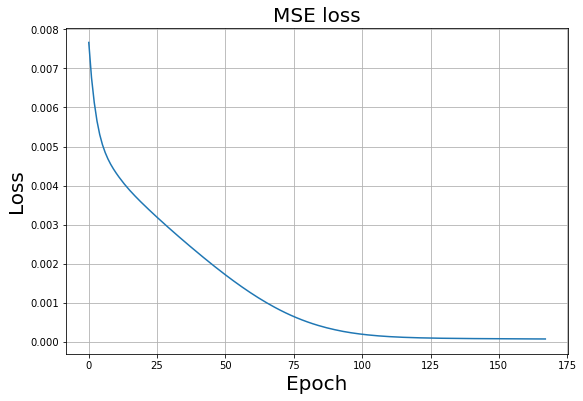

In [9]:
plt.figure(figsize=(9,6))
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("MSE loss", fontsize=20)
plt.show()

In [10]:
avg_test_loss = test_regr(airfoil_model, loss_function, test_loader, return_loss=True)

print(f"Average test MSE = {avg_test_loss:.5f}")   

Average test MSE = 0.00047


### Test on OOD data

In [11]:
avg_OOD_loss = test_regr(airfoil_model, loss_function, OOD_loader, return_loss=True)

print(f"Average OOD loss = {avg_OOD_loss:.10f}")  
print(f"Average OOD loss to train loss ratio: {avg_OOD_loss / avg_train_loss : .3f}")
print(f"Average OOD loss to test loss ratio: {avg_OOD_loss / avg_test_loss : .3f}")

Average OOD loss = 0.0020071200
Average OOD loss to train loss ratio:  26.980
Average OOD loss to test loss ratio:  4.267


### Abs

In [ ]:
activation = 'abs'

Average Train MSE: 0.00005


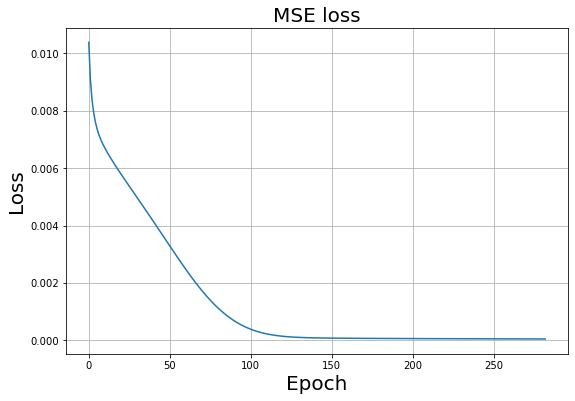

Average test MSE = 0.00036
Average OOD loss = 0.0029898278
Average OOD loss to train loss ratio:  64.036
Average OOD loss to test loss ratio:  8.262


In [13]:
airfoil_model = MLP(n_features, 1, [n_hidden_1, n_hidden_2], activation, batch_norm=True).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(airfoil_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train
train_losses = fit_regr(airfoil_model, loss_function, optimizer, train_loader, 
    n_epochs=n_epochs, verbose=0, early_stopping='dev', return_losses=True)
avg_train_loss = train_losses[-1]

print(f"Average Train MSE: {avg_train_loss:.5f}")  

plt.figure(figsize=(9,6))
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("MSE loss", fontsize=20)
plt.show()

avg_test_loss = test_regr(airfoil_model, loss_function, test_loader, return_loss=True)

print(f"Average test MSE = {avg_test_loss:.5f}")   

avg_OOD_loss = test_regr(airfoil_model, loss_function, OOD_loader, return_loss=True)

print(f"Average OOD loss = {avg_OOD_loss:.10f}")  
print(f"Average OOD loss to train loss ratio: {avg_OOD_loss / avg_train_loss : .3f}")
print(f"Average OOD loss to test loss ratio: {avg_OOD_loss / avg_test_loss : .3f}")

### Now that we have a pipeline ready, let's use 10-fold cross validation to see the performance on the whole data

In [19]:
def pipeline(X_train, X_test, y_train, y_test, verbose=0):
    
    # Transformation required for regression problem
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # Tensor datasets
    train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=False)
    test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=False)

    # Data loaders on gpu
    train_loader = data_loaders.create_loader(train_dataset, batch_size, device, num_workers=0)
    test_loader = data_loaders.create_loader(test_dataset, batch_size, device, num_workers=0)

    # Model setup
    # airfoil_model = model.airfoil_NN(n_features, n_hidden_1, n_hidden_2).to(device)
    # airfoil_model = model.airfoil_DNN(n_features, 512, 256, 128, 3).to(device)
    airfoil_model = MLP(n_features, 1, [n_hidden_1, n_hidden_2], 'tanh', batch_norm=True).to(device)

    loss_function = nn.MSELoss()
    optimizer = optim.Adam(airfoil_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # fit function optionally returns a list with the epoch-wise losses
    train_loss = fit_regr(airfoil_model, loss_function, optimizer, train_loader, 
                 n_epochs=n_epochs, verbose=0, early_stopping=True, return_losses=True) 
    test_loss = test_regr(airfoil_model, loss_function, test_loader, verbose=0, return_loss=True) 
    
    if verbose:
        print(f"Average Train MSE Loss: {train_loss[-1] : .10f}")
        print(f"Average Test MSE Loss : {test_loss : .10f}" )

    return train_loss, test_loss                 # train loss is a list, test loss is a float
 


Training on fold no. 1
Average Train MSE Loss:  0.0001551312
Average Test MSE Loss :  0.0003811459

Training on fold no. 2
Average Train MSE Loss:  0.0001144262
Average Test MSE Loss :  0.0008711475

Train losses: [0.00015513 0.00011443]

Test losses: [0.00038115 0.00087115]

Avg train loss over all folds: 0.00013
Avg total train loss over all folds: 0.08100

Avg test loss over all folds: 0.00063
Avg total test loss over all folds: 0.37569


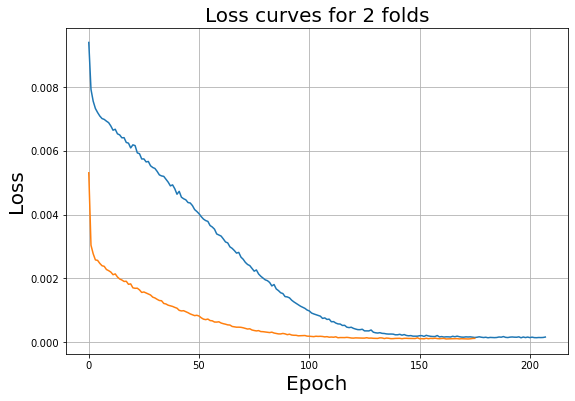

CPU times: total: 11 s
Wall time: 11.2 s


In [20]:
%%time 

n_splits = 2
kf = KFold(n_splits)

train_losses = np.zeros(n_splits)
test_losses = np.zeros(n_splits)
train_losses_plot = []                           # for plotting loss curves
for i, (train_index, test_index) in enumerate(kf.split(X)):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("\nTraining on fold no. %d" %(i+1))
    epoch_wise_train_losses, test_losses[i] = pipeline(X_train, X_test, y_train, y_test, verbose=1)
    train_losses[i] = epoch_wise_train_losses[-1]
    train_losses_plot.append(epoch_wise_train_losses)
    
print("\nTrain losses:", train_losses)
print("\nTest losses:", test_losses)

avg_train_loss_k_folds = train_losses.mean() 
avg_test_loss_k_folds = test_losses.mean() 
print(f"\nAvg train loss over all folds: {avg_train_loss_k_folds :.5f}")
print(f"Avg total train loss over all folds: {len(X_train) * avg_train_loss_k_folds :.5f}")
print(f"\nAvg test loss over all folds: {avg_test_loss_k_folds :.5f}")
print(f"Avg total test loss over all folds: {len(X_test) * avg_test_loss_k_folds :.5f}")

plt.figure(figsize=(9,6))
for losses in train_losses_plot:
    plt.plot(losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title(f"Loss curves for {n_splits} folds", fontsize=20)
plt.show()

### Test on OOD data

In [15]:
avg_OOD_loss = test_regr(airfoil_model, loss_function, OOD_loader, return_loss=True)

print(f"Average OOD loss = {avg_OOD_loss:.10f}")  
print(f"Average OOD loss to train loss ratio: {avg_OOD_loss / avg_train_loss_k_folds : .3f}")
print(f"Average OOD loss to test loss ratio: {avg_OOD_loss / avg_test_loss_k_folds : .3f}")

Average OOD loss = 0.0008063013
Average OOD loss to train loss ratio:  6.112
Average OOD loss to test loss ratio:  1.009


### We see that the loss on OOD data is higher, which is a good sign for the domain splitting method.

## Now for the Bayesian treatment

In [12]:
airfoil_model

MLP(
  (layer_0): Linear(in_features=5, out_features=100, bias=True)
  (layer_1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): Linear(in_features=100, out_features=30, bias=True)
  (layer_3): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_4): Linear(in_features=30, out_features=1, bias=True)
)

In [39]:
nn.Linear(30, 100).out_features

100

In [46]:
net = nn.Sequential(
    nn.Linear(n_features, n_hidden_1),
    nn.ReLU(),
    nn.BatchNorm1d(n_hidden_1),
    nn.Linear(n_hidden_1, n_hidden_2),
    nn.ReLU(),
    nn.BatchNorm1d(n_hidden_2),
    nn.Linear(n_hidden_2, 1)
).to(device)

class TyXeNN(nn.Module):
    def __init__(self, n_features, n_classes, batch_norm=False):
        super(TyXeNN, self).__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.linear1 = nn.Linear(self.n_features, 30)
        self.bn1 = nn.BatchNorm1d(self.linear1.out_features, device=device)
        self.linear2 = nn.Linear(30, 100)
        self.bn2 = nn.BatchNorm1d(self.linear2.out_features, device=device)
        self.linear3 = nn.Linear(100, 1) 
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        # if batch_norm:
        #     x = nn.BatchNorm1d(self.linear1.out_features, device=device)(x)
        x = self.bn1(x)
        x = F.relu(self.linear2(x))
        x = self.bn2(x)
        # if batch_norm:
        #     x = nn.BatchNorm1d(self.linear2.out_features, device=device)(x)
        x = self.linear3(x)
        return x
    
net = TyXeNN(n_features, 1).to(device)
# fit_regr(net, loss_function, optimizer, train_loader, n_epochs, early_stopping='dev')

In [51]:
# Model 
# net = airfoil_model
# net = MLP(n_features, 1, [n_hidden_1, n_hidden_2], 'sigmoid', batch_norm=True).to(device)
net = MLP(n_features, 1, [n_hidden_1, n_hidden_2], 'tanh', batch_norm=False).to(device)
# net = TyXeNN(n_features, 1).to(device)

prior = tyxe.priors.IIDPrior(dist.Normal(
        torch.tensor(0, device=device, dtype=torch.float),
        torch.tensor(1, device=device, dtype=torch.float)))
prior_name = ", IID prior"
likelihood = tyxe.likelihoods.HomoskedasticGaussian(len(X_train), scale=1e-2)
likelihood_name = ", Homoskedastic Gaussian likelihood"
kernel = partial(pyro.infer.mcmc.HMC, step_size=1e-3, num_steps=20, target_accept_prob=0.7)
kernel_name = "HMC"
bnn = tyxe.bnn.MCMC_BNN(net, prior, likelihood, kernel)
bnn.name = kernel_name + ", MCMC BNN" + likelihood_name + prior_name
setattr(bnn, 'hidden_layers', [n_hidden_1, n_hidden_2])

# Fit
pyro.clear_param_store()
bnn.fit(train_loader, 20000, warmup_steps=50000)

Warmup:   0%|▏                                     | 60/15000 [1:05:52, 65.87s/it, step size=3.76e-05, acc. prob=0.705]


KeyboardInterrupt: 

### We evaluate the model on train, test and OOD data.

In [49]:
posterior_samples = 1000

# Train
train_evaluation = evaluate_regr(bnn, train_loader, loss_function, posterior_samples=posterior_samples, rounded=10,
                           dataset="airfoil, Train data", device=device)
test_evaluation = evaluate_regr(bnn, test_loader, loss_function, posterior_samples=posterior_samples, rounded=10,
                           dataset="airfoil, Test data", device=device)
OOD_evaluation = evaluate_regr(bnn, OOD_loader, loss_function, posterior_samples=posterior_samples, rounded=10,
                           dataset="airfoil, OOD data", device=device)

print("Train evaluation:")
util.print_dict(train_evaluation)

print("\nTest evaluation:")
util.print_dict(test_evaluation)

print("\nOOD evaluation:")
util.print_dict(OOD_evaluation)

Train evaluation:
Inference type: HMC, MCMC BNN, Homoskedastic Gaussian likelihood, IID prior
Evaluated on: airfoil, Train data
Neural network: [100, 30]
Number of posterior samples: 1000
Average NLPD: 16.90971
SD of NLPD: 34.91543
Total NLPD: 16233.32
Average loss: 6.5038e-05
Total loss: 0.0624364421

Test evaluation:
Inference type: HMC, MCMC BNN, Homoskedastic Gaussian likelihood, IID prior
Evaluated on: airfoil, Test data
Neural network: [100, 30]
Number of posterior samples: 1000
Average NLPD: 15.843596
SD of NLPD: 28.851536
Total NLPD: 3818.3064
Average loss: 6.43375e-05
Total loss: 0.0155053306

OOD evaluation:
Inference type: HMC, MCMC BNN, Homoskedastic Gaussian likelihood, IID prior
Evaluated on: airfoil, OOD data
Neural network: [100, 30]
Number of posterior samples: 1000
Average NLPD: 178.00049
SD of NLPD: 320.1241
Total NLPD: 53756.15
Average loss: 0.000602215
Total loss: 0.1818689276


### Variational inference


In [19]:
# Only run this to select new domain split

def reset():
    # Data
    dom_idx, OOD_idx = hyperplane_split(df.values, OOD_size=0.2, verbose=1)

    # Minmax scaling for better network performace
    scaler = MinMaxScaler()
    D = df[dom_idx].values
    D = scaler.fit_transform(D)

    # Split in-domain data to data and labels
    X, y = D[:,:-1], D[:,-1]

    # Split to train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

    # Separate OOD data
    OOD = df[OOD_idx].values
    OOD = scaler.transform(OOD)         # need to also transform it to be compatible with the NN.
    X_OOD, y_OOD = OOD[:,:-1], OOD[:,-1]

    # Split to train / test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

    # Transformation required for regression problem
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    y_OOD = y_OOD.reshape(-1, 1)

    # Tensor datasets
    train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=False)
    test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=False)
    OOD_dataset = data_loaders.create_torch_dataset(X_OOD, y_OOD, to_LongTensor=False)

    # Data loaders on gpu
    train_loader = data_loaders.create_loader(train_dataset, batch_size_train, device)
    test_loader = data_loaders.create_loader(test_dataset, batch_size_test, device)
    OOD_loader = data_loaders.create_loader(OOD_dataset, batch_size_test, device)
    
    pass

# reset()

In [30]:
train_size = len(X_train)
test_size = len(X_test)

# Model 
var_net = MLP(n_features, 1, [n_hidden_1, n_hidden_2], 'relu', batch_norm=True).to(device)
prior = tyxe.priors.IIDPrior(
    dist.Normal(
        torch.tensor(0, device=device, dtype=torch.float),
        torch.tensor(1, device=device, dtype=torch.float),
    ),
)
prior_name = ", IID prior"
obs_model = tyxe.likelihoods.HomoskedasticGaussian(train_size, scale=0.01)
likelihood_name = ", Homoskedastic Gaussian likelihood"
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
guide_name = "Mean field"
var_bnn = tyxe.VariationalBNN(var_net, prior, obs_model, guide_builder)
var_bnn.name = guide_name + " Variational BNN" + likelihood_name + prior_name

In [31]:
# Fit
n_epochs = 30
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []    
def callback(bnn, i, e):
    elbos.append(e)
var_bnn.fit(train_loader, optim, n_epochs, callback, device=device)
setattr(var_bnn, 'hidden_layers', [n_hidden_1, n_hidden_2])

In [32]:
posterior_samples = 100

# Train
train_evaluation = evaluate_regr(var_bnn, train_loader, loss_function, posterior_samples=posterior_samples, rounded=10,
                           dataset="airfoil, Train data", device=device)
test_evaluation = evaluate_regr(var_bnn, test_loader, loss_function, posterior_samples=posterior_samples, rounded=10,
                           dataset="airfoil, Test data", device=device)
OOD_evaluation = evaluate_regr(var_bnn, OOD_loader, loss_function, posterior_samples=posterior_samples, rounded=10,
                           dataset="airfoil, OOD data", device=device)


print("Train evaluation:")
util.print_dict(train_evaluation)

print("\nTest evaluation:")
util.print_dict(test_evaluation)

print("\nOOD evaluation:")
util.print_dict(OOD_evaluation)

Train evaluation:
Inference type: Mean field Variational BNN, Homoskedastic Gaussian likelihood, IID prior
Evaluated on: airfoil, Train data
Neural network: [100, 30]
Number of posterior samples: 100
Average NLPD: 3.785821
SD of NLPD: 20.737915
Total NLPD: 3634.388
Average loss: 0.000131408
Total loss: 0.1261516609

Test evaluation:
Inference type: Mean field Variational BNN, Homoskedastic Gaussian likelihood, IID prior
Evaluated on: airfoil, Test data
Neural network: [100, 30]
Number of posterior samples: 100
Average NLPD: 3.984973
SD of NLPD: 13.698948
Total NLPD: 960.37836
Average loss: 0.0001412031
Total loss: 0.0340299541

OOD evaluation:
Inference type: Mean field Variational BNN, Homoskedastic Gaussian likelihood, IID prior
Evaluated on: airfoil, OOD data
Neural network: [100, 30]
Number of posterior samples: 100
Average NLPD: 134.30888
SD of NLPD: 285.7068
Total NLPD: 40561.28
Average loss: 0.0010850132
Total loss: 0.3276739903


# Draft below

In [25]:
X_ood, y_ood = data_loaders.separate_torch_dataset(OOD_dataset, device=device)

var_bnn.evaluate(X_ood, y_ood, posterior_samples, reduction='mean')

(tensor(0., device='cuda:0'), tensor(416.4776, device='cuda:0'))

In the case of **Homoskedastic Gaussian** likelihood:

Instead of calculating the likelihood for each test point
$$ p(y_{test} | x_{test}, \theta_t) = N ( f_{\theta} (x_{test}), sd) $$
and then doing Bayesian model averaging
$$ p ( y_{test} | x_{test}, \theta) = \frac{1}{T} \sum_t p(y_{test} | x_{test}, \theta_t), \ \ \ \ \theta_t \sim p(\theta | x,y) \ \ \ \ \ \text{(average over posterior samples)}$$
to then calculate the NLPD
$$ NLPD = -\frac{1}{N} \sum_i \log p(y_i | x_i, \theta), \ \ \ \ \ \text{(average over data)}$$

could we split the data into batches and calculate an average prediction for each batch B:
$$ \bar{y}_{\text{B}} = \frac{1}{|\text{B}|} \sum_{x \in \text{B}} f_{\theta}(x), \ \ \ \ \ \text{B=batch} $$
and then compare against that average value?

That is, for each $(x_{test}, y_{test})$ in batch B, calculate:
$$ p( y_{test} | x_{test}, \theta) = \mathcal{N}( \bar{y}_{\text{B}}, \sigma \text{*}), $$
and then calculate the NLPD as before
$$ NLPD = -\frac{1}{N} \sum_i \log p(y_{test} | x_{test}, \theta). $$


\*where $\sigma$ is the common posterior sd (due to HG assumption)

### you are here

In [16]:
posterior_samples = 32

nllh = torch.empty(0, device='cuda')
for X, target in test_loader:
    
    pred_mean, pred_sd = bnn.predict(X, num_predictions=posterior_samples)
    
    nllh_batch = -1 * norm(pred_mean, pred_sd).log_prob(target)
    nllh = torch.cat((nllh, nllh_batch))
    
nlpd = nllh.mean()
nlpd

tensor(14.1355, device='cuda:0')

In [115]:
NLPD(bnn, train_loader, 1000)
    

(tensor(1.0815, device='cuda:0'),
 tensor(0.1093, device='cuda:0'),
 tensor(1038.2397, device='cuda:0'))

In [33]:
def NLPD_2(
    model, 
    loader, 
    posterior_samples, 
    likelihood = "Homoskedastic Gaussian",   # TODO: obtain this from model, implement other likelihoods
    device='cuda',
    verbose=0,
    ):
    """
    Calculate mean, sd and total NLPD for regression model.
    Used inside evaluate_regr().
    """
    
    if likelihood == "Homoskedastic Gaussian":
        sd = util.posterior_sd(model)
    else:
        raise("This type of likelihood is not impleneted yet.")
        
    # torch tensor with number of posterior samples
    T = torch.tensor(posterior_samples)
    
    NLPD = torch.empty(0, device='cuda')
    with torch.no_grad():
        for data, target in loader:
            # pred is a matrix with dimensions (posterior_samples, batch_size, 1)
            pred = model.predict(data, num_predictions=posterior_samples, aggregate=False)
            
            # warning: heavily vectorized operations ahead!
            if likelihood == "Homoskedastic Gaussian":
                # we transpose pred matrix and vanish the 3rd dimension (it's just 1)
                # resulting matrix is of dimension (batch_size, posterior_samples)
                log_p = norm(pred[:, :, -1].T, sd).log_prob(target)
            else:
                raise("This type of likelihood is not impleneted yet.")
            
            # calculate NLPD
            # log_p is now a matrix, we calculate logsumexp along axis=1
            nlpd = -( torch.logsumexp(log_p, 1) - T.log() )
            NLPD = torch.cat((NLPD, nlpd))

    avg_NLPD = NLPD.mean()
    sd_NLPD = NLPD.std()
    total_NLPD = NLPD.sum()
    
    if verbose==1:
        print("Average NLPD =", avg_NLPD.cpu().detach().numpy())
        print("SD of NLPD =", sd_NLPD.cpu().detach().numpy())
        print("Total NLPD =", total_NLPD.cpu().detach().numpy())
    
    return avg_NLPD, sd_NLPD, total_NLPD

In [ ]:
T = number of posterior samples
B = batch size

nlpd = torch.empty(0, device='cuda')
for X, target in loader:
    
    # pred is a matrix of dimensions (T, B, 1)
    pred_mean = bnn.predict(X, num_predictions=posterior_samples, aggregate=False)
    
    # transpose pred matrix and vanish the 3rd "fake" dimension
    # resulting matrix is of dimension BxT
    pred = pred[:, :, -1].T
    
    # Homoskedastic Gaussian likelihood implies all parameters have a common shared posterior variance
    sd = posterior_sd(bnn)      # flatten all parameters from all posterior samples and calculate the common sd
    
    # Calculate negative log likelihoods (or "log probabilities")
    # nllh is a matrix of dimension BxT
    # (nllh)_ij is the log likelihood of target_i conditioned on output of "posterior" network j with input X_i and the common sd
    nllh = -1 * norm(pred, sd).log_prob(target)     # heavily vectorized pytorch magic
    
    # calculate NLPD
    # logsumexp is calculated along axis 1 (one resulting value for each data point)
    # result is of dimension Bx1
    nlpd_batch = torch.logsumexp(log_p, 1) - T.log()     
    
    nlpd = torch.cat((nlpd, nlpd_batch))
    
avg_nlpd = nlpd.mean()

In [ ]:
# Below is empty space, to allow github scrolling at the bottom

In [41]:
airfoil_model.hidden_layers

[100, 30]

In [40]:
airfoil_model

MLP(
  (layer_0): Linear(in_features=5, out_features=100, bias=True)
  (layer_1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): Linear(in_features=100, out_features=30, bias=True)
  (layer_3): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_4): Linear(in_features=30, out_features=1, bias=True)
)

In [ ]:
nn.Sequential(airfoil_model.layer_0)

In [43]:
model = MLP(n_features, 1, [100, 30, 30], 'sigmoid',  batch_norm=True).to(device)
model

MLP(
  (layer_0): Linear(in_features=5, out_features=100, bias=True)
  (layer_1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): Linear(in_features=100, out_features=30, bias=True)
  (layer_3): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_4): Linear(in_features=30, out_features=30, bias=True)
  (layer_5): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [49]:
'mcmc' or 'vi' in 'laplace'

False

In [51]:
'variatonal' in 'Variational'.lower()

False

In [52]:
'Variational'.lower()

'variational'

In [55]:
'variational' in 'Mean field Variational BNN, Homoskedastic Gaussian likelihood, IID prior'.lower().split()

True